In [0]:
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import datetime
import matplotlib.pyplot as plot
# For gathering some metrics
from sklearn import metrics

In [94]:
# Get the data for the last 10 years from today. Set start date as 10 years in the past
start = datetime.datetime(datetime.datetime.today().year-10, datetime.datetime.today().month, datetime.datetime.today().day)
end = datetime.datetime.today()
print('start ', start)
print('end   ', end)

start  2009-09-13 00:00:00
end    2019-09-13 09:14:00.917357


In [0]:
# Populate the dataframe that fetches the Broadcom Stock data from yahoo finance
df = web.DataReader("AVGO", 'yahoo', start, end)

In [96]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-09-14,16.90,16.309999,16.639999,16.650000,1614500.0,14.093755
2009-09-15,17.35,16.629999,17.250000,17.180000,1986900.0,14.542389
2009-09-16,17.75,17.110001,17.400000,17.580000,2021100.0,14.880978
2009-09-17,17.90,16.530001,17.660000,16.639999,1446400.0,14.085292
2009-09-18,17.02,16.180000,16.570000,16.200001,899900.0,13.712848


In [97]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-06,293.299988,289.299988,291.850006,291.910004,1374800.0,291.910004
2019-09-09,297.200012,290.399994,295.000000,292.609985,2168600.0,292.609985
2019-09-10,294.450012,288.820007,291.350006,294.440002,2085000.0,294.440002
2019-09-11,298.779999,294.549988,296.320007,298.010010,1926000.0,298.010010
2019-09-12,302.329987,296.470001,301.429993,300.579987,3034200.0,300.579987


In [98]:
df.shape

(2517, 6)

In [99]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000
mean,117.391911,114.518288,116.010218,116.021538,2.603986e+06,108.698738
std,93.639402,91.588293,92.656275,92.647798,2.312092e+06,90.605291
min,14.820000,14.330000,14.600000,14.490000,3.080000e+04,12.265377
25%,34.349998,33.340000,33.840000,33.869999,1.495200e+06,29.180447
50%,82.459999,79.300003,81.510002,81.029999,2.174000e+06,73.283127
75%,211.710007,208.039993,210.250000,210.369995,3.116100e+06,200.121857
max,323.200012,318.690002,321.040009,320.529999,5.602800e+07,317.486084


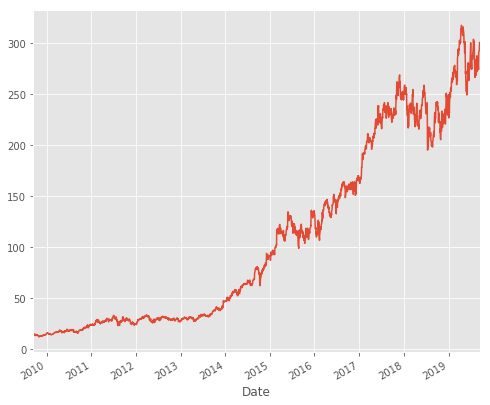

In [100]:
df['Adj Close'].plot()

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [102]:
mavg.tail()

Date
2019-09-06    284.654510
2019-09-09    284.425857
2019-09-10    284.195396
2019-09-11    284.019554
2019-09-12    283.905268
Name: Adj Close, dtype: float64

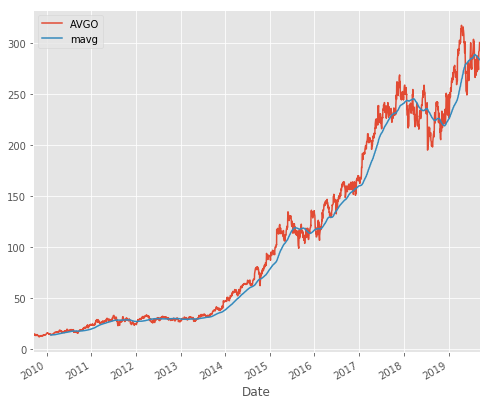

In [103]:
# Plot moving average of AVGO
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AVGO')
mavg.plot(label='mavg')
plt.legend()

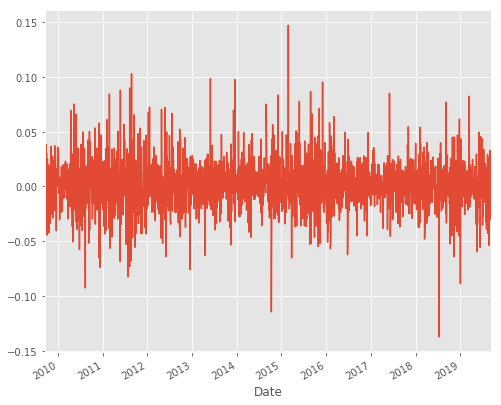

In [104]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
dfcomp = web.DataReader(['AVGO', 'GE', 'GOOGL', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [0]:
retscomp = dfcomp.pct_change()

In [0]:
corr = retscomp.corr()

Text(0, 0.5, 'Returns GOOGL')

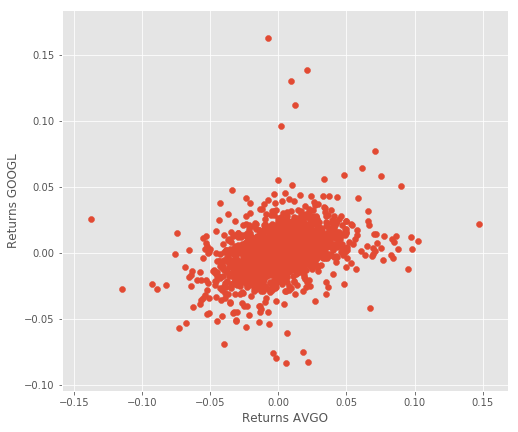

In [108]:
plt.scatter(retscomp.AVGO, retscomp.GOOGL)
plt.xlabel('Returns AVGO')
plt.ylabel('Returns GOOGL')

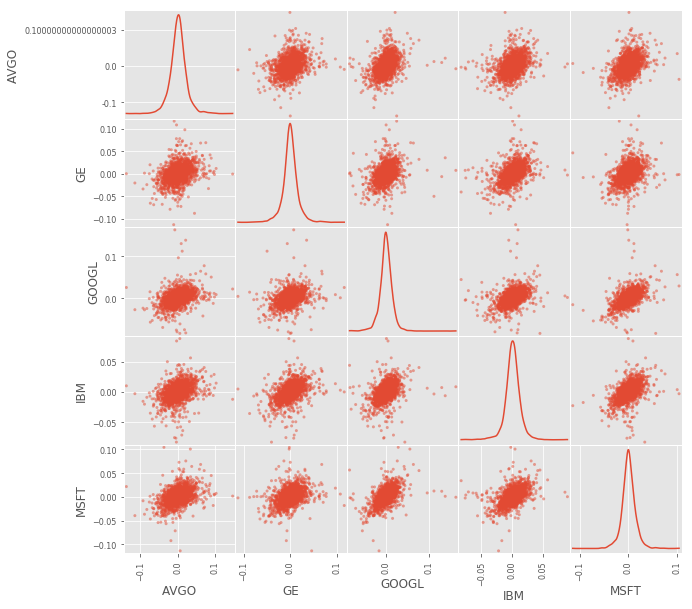

In [109]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

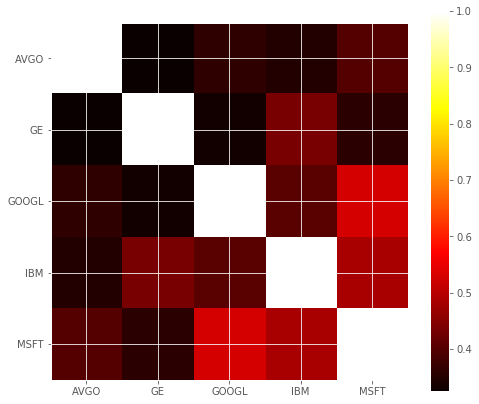

In [110]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

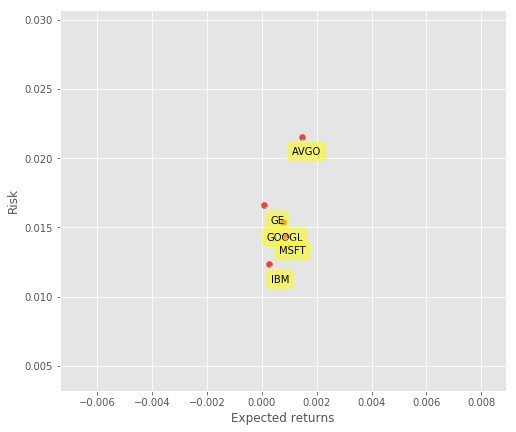

In [111]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

In [0]:
import math
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [0]:
import numpy as np
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [0]:
from sklearn import preprocessing
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [0]:
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [0]:
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [122]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [123]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [124]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [125]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is', confidencereg)
print('The quadratic regression 2 confidence is', confidencepoly2)
print('The quadratic regression 3 confidence is', confidencepoly3)
print('The knn regression confidence is', confidenceknn)

The linear regression confidence is 0.9825594053994341
The quadratic regression 2 confidence is 0.9821931095958172
The quadratic regression 3 confidence is 0.9826680208807957
The knn regression confidence is 0.9688050814474412


In [0]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

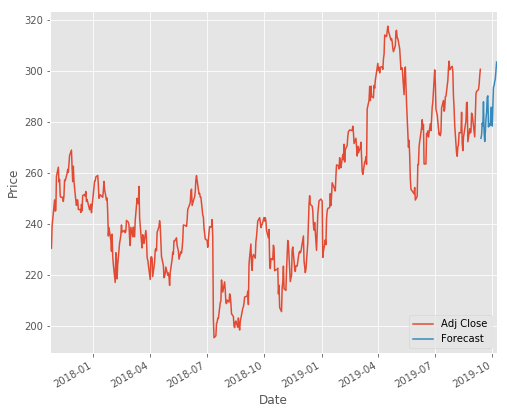

In [127]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()